# 02 监督学习

## 1 分类与回归

监督机器学习问题主要有两种：**分类（classification）**与**回归（regression）**。

分类问题的目标时预测**类别标签（class label）**。分类问题可以分为**二分类（binary classification）**和**多分类（multiclass classification）**。在二分类问题中，通常将其中一个类别称为**正类（positive class）**，另一个类别称为**反类（negative class）**。

回归任务的目标是预测一个连续值，即编程语言中的**浮点数（floating-point number）**或数学语言中的**实数（real number）**。

区分分类问题和回归问题的方法：判断输出是否有连续性。

## 2 泛化、过拟合与欠拟合

如果一个模型能对没见过的数据做出准确的预测，我们就说它能够从训练集**泛化（generalize）**到测试集。机器学习的目标之一是构建一个泛化精度尽可能高的模型。

如前所述，判断一个算法在新数据上表现好坏的唯一度量是在测试集上的评估。理论上，我们可以构建非常复杂的模型，那么在训练集上的精度想要有多高就有多高。然而从直觉上（在数学上也可以证明）看，我们认为简单的模型对新数据的泛化能力更好。因此我们总是想要找一个最简单的模型。

> 考虑通过顾客的特征来预测顾客是否会买船，如果规律是“年龄大于 50 岁的顾客会买船”且该规律可以解释所有顾客的行为，你们我们更愿意相信这一条规律，而不是与年龄、子女、婚姻状况都有关的那条规律。

构建一个对现有信息量来说过于复杂的模型，被称为**过拟合（overfitting）**。如果在拟合模型时过分关注训练集的细节，得到一个在训练集上表现很好但不能泛化到新数据上的模型，你们就存在过拟合。

反之，如果模型过于简单，那么就可能无法抓住数据的全部内容以及数据中的变化，模型甚至在训练集上的表现都会很差。选择过于简单的模型被称为**欠拟合（underfitting）**。

模型越复杂，在训练集上的预测效果越好，但当模型过于复杂时，我们开始过于关注训练集上每个单独的数据点，模型就不能很好地泛化到新数据上。在过拟合和欠拟合之间存在一个最佳位置，可以得到最好的泛化效果，这就是我们想要的模型。

<center><img src="../asset/02-1.png" alt="模型复杂度与训练精度和测试精度之间的权衡" width="600"></center>

模型复杂度与数据集的关系：

- 数据集中包含的苏据点的变化范围越大，在不发生过拟合的情况下可以使用的模型就越复杂。
- 更大的数据集可以用来构建更复杂的模型。

收集更多的数据，适当构建更复杂的模型，对监督学习任务往往特别有用。
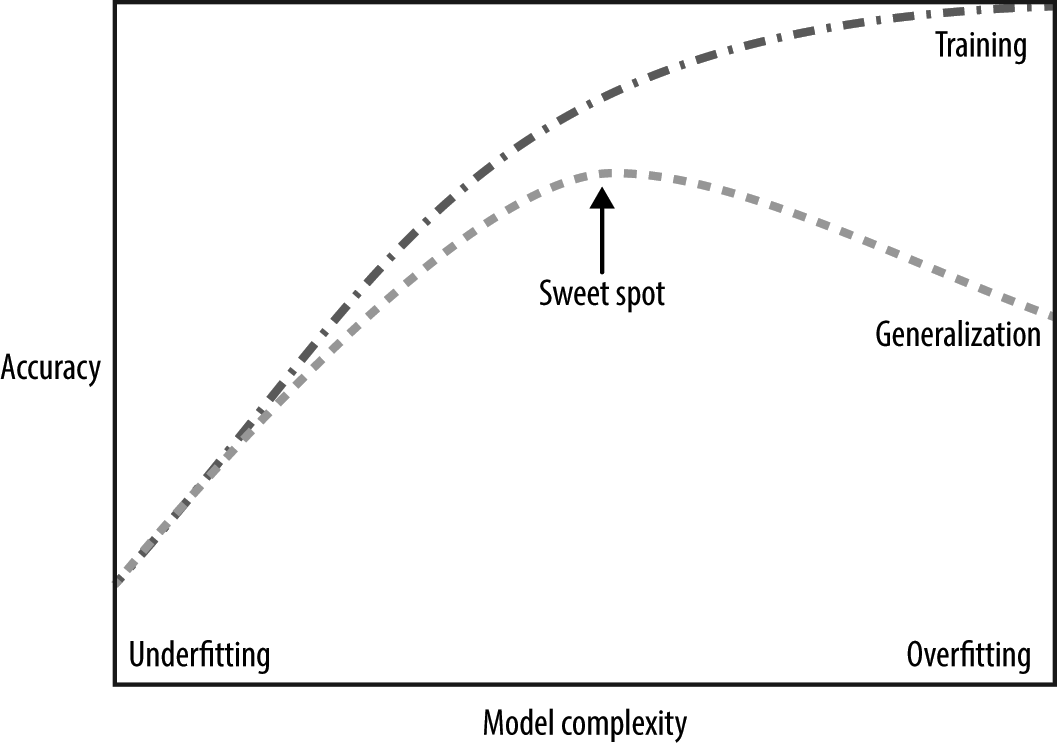

## 3 监督学习算法

### 3.1 一些样本数据集

下面先给出一些数据集，以便后面将其用于说明各个算法。包括两个模拟数据集和两个实际的数据集：

1. 二分类模拟数据集 `forge`。
2. 回归模拟数据集 `wave`。
3. 威斯康星州乳腺癌数据集 `cancer`：记录乳腺癌的临床测量数据，每个肿瘤被标记为良性（benign）或恶性（malignant），该数据集共有 569 个数据点（212 个良性和 357 个恶性）和 30 个特征。
4. 波斯顿房价数据集 `boston`：利用犯罪率、是否邻近查尔斯河等信息来预测 20 世纪 70 年代波士顿地区房屋价格的中位数，该数据集包含 506 个数据点和 13 个特征。这里对原有数据集的特征做一些扩展，将 13 个特征之间的乘积（又称为**交互项**）也作为特征。

In [81]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.datasets import make_blobs, load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams["font.sans-serif"] = "Noto Serif SC"
plt.rcParams["axes.unicode_minus"] = False

def make_forge():
    x, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(x), dtype=bool)
    mask[np.array([0, 1, 5, 26])] = 0
    x, y = x[mask], y[mask]
    return x, y

def make_wave(n_samples=100):
    rnd = np.random.RandomState(42)
    x = rnd.uniform(-3, 3, size=n_samples)
    y_no_noise = (np.sin(4 * x) + x)
    y = (y_no_noise + rnd.normal(size=len(x))) / 2
    return x.reshape(-1, 1), y

def make_cancer():
    return load_breast_cancer()

def make_extended_boston():
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    y = raw_df.values[1::2, 2]
    x = MinMaxScaler().fit_transform(data)
    x = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
    return x, y

### 3.2 K 近邻

k-NN 苏纳夫是最简单的机器学习算法，构建模型只需保存训练数据集即可。对新数据点做预测时，算法会在训练数据集中找到最近的数据点，也就是它的“最邻近”。

#### 3.2.1 k 近邻分类

k-NN 算法最简单的版本时只考虑一个邻居，此时离预测数据点最近的训练数据点的已知输出即为预测结果。考虑取 k 个邻居时，对每个预测数据点，计数其 k 个邻居中各个类别的数量，然后将数量最多的类别作为预测结果。

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X, y = make_forge()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = KNeighborsClassifier(n_neighbors=3) # 指定邻居个数为 3
clf.fit(X_train, y_train) # 使用训练集对分类器进行拟合
print("测试数据集预测结果：{}".format(clf.predict(X_test)))

测试数据集预测结果：[1 0 1 0 1 0 0]


In [83]:
print("模型精度：{}".format(clf.score(X_test, y_test)))

模型精度：0.8571428571428571


#### 3.2.2 分析 KNighborsClassifier

对于二维数据集，可以画出所有可能的预测点的预测结果。根据 xy 平面中每个点所属的类别对平面进行着色，可以查看**决策边界（decision boundary）**，即算法对类别 0 和类别 1 的分界线。随着邻居个数的增多，决策边界趋近于平滑，而更平滑的边界对应更简单的模型。换句话说，使用较少的邻居对应更高的模型复杂度，而使用较多的邻居对应更低的模型复杂度。当邻居个数等于训练集中数据点的个数时，每个预测点的邻居完全相同，所有预测结果完全相同（这显然是无意义的）。

下面使用乳腺癌数据集对前面讨论的模型复杂度与泛化能力之间的关系做进一步证实。

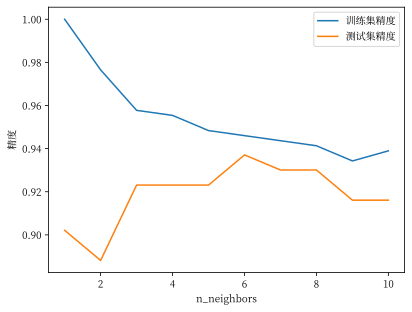

In [84]:
cancer = make_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data,
    cancer.target,
    stratify=cancer.target,
    random_state=66
)
training_accuracy = []
test_accuracy = []
# n_neighbors 取值从 1 到 10
neighbors_settings = range(1, 11)
for n_neighbors in neighbors_settings:
    # 构建模型
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # 记录训练集精度
    training_accuracy.append(clf.score(X_train, y_train))
    # 记录泛化精度
    test_accuracy.append(clf.score(X_test, y_test))

plt.plot(neighbors_settings, training_accuracy, label="训练集精度")
plt.plot(neighbors_settings, test_accuracy, label="测试集精度")
plt.ylabel("精度")
plt.xlabel("n_neighbors")
plt.legend()

由上图可知，邻居越多，训练集精度阅读，模型越简单。单一近邻时模型过于复杂，而 10 个邻居时模型过于简单，性能很差，无法很好地泛化。在中间的某处有一个最优点，此时模型在训练集上的精度与泛化精度都相对较高。在这个例子中，最优点位于 6 个邻居处。

#### 3.2.4 k 近邻回归

k 近邻算法还可用于回归，该算法在 `scikit-learn` 的 `KNeighborsRegressor` 类中实现。其用法与 `KNeighborsClassifier` 类似。下面使用 `wave` 数据集进行回归。

In [85]:
from sklearn.neighbors import KNeighborsRegressor

X, y = make_wave(n_samples=40)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
reg = KNeighborsRegressor(n_neighbors=3)
reg.fit(X_train, y_train)
print("测试集预测结果：\n{}".format(reg.predict(X_test)))
print("测试集 R^2：{:.2f}".format(reg.score(X_test, y_test)))

测试集预测结果：
[-0.05396539  0.35686046  1.13671923 -1.89415682 -1.13881398 -1.63113382
  0.35686046  0.91241374 -0.44680446 -1.13881398]
测试集 R^2：0.83


#### 3.2.4 分析 KNeighborsRegressor

对于一维数据集，可以查看所有可能输入值的预测结果。为此，将输入值在水平轴上画出，将预测结果在垂直轴上画出，从左到右画出所有数据点。这样得到的图像就是回归的**预测曲线（prediction curve）**。

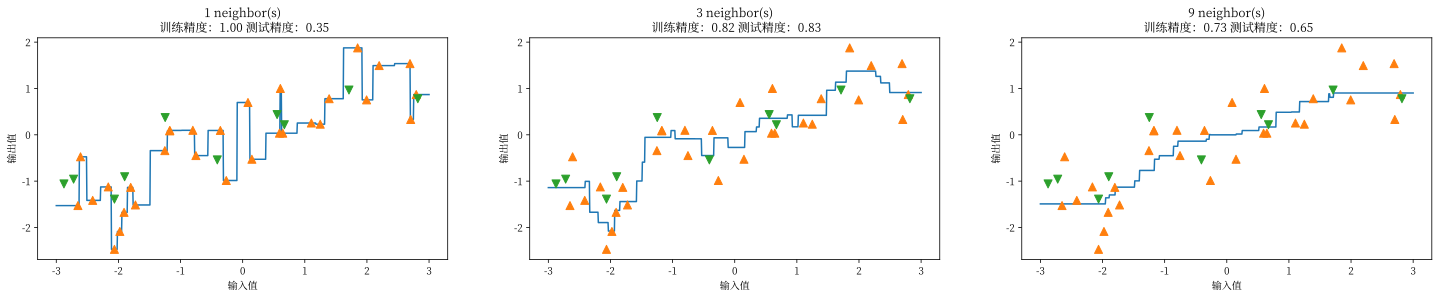

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(25, 4))
# 创建 1,000 个数据点，在 -3 和 3 之间均匀分布
line = np.linspace(-3, 3, 1000).reshape(-1, 1)
for n_neighbors, ax in zip([1, 3, 9], axes):
    # 利用 1 个、3 个或 9 个邻居分别进行预测
    reg = KNeighborsRegressor(n_neighbors=n_neighbors)
    reg.fit(X_train, y_train)
    ax.plot(line, reg.predict(line))
    ax.plot(X_train, y_train, "^", markersize=8)
    ax.plot(X_test, y_test, "v", markersize=8)
    ax.set_title(
        "{} neighbor(s)\n 训练精度：{:.2f} 测试精度：{:.2f}".format(
            n_neighbors,
            reg.score(X_train, y_train),
            reg.score(X_test, y_test)
        )
    )
    ax.set_xlabel("输入值")
    ax.set_ylabel("输出值")

由上图，仅使用单一邻居时，训练集中每个店都对预测结果有影响，预测结果的图像结果所有数据点，导致预测结果非常不稳定。使用更多的邻居时，预测结果变得更加平滑，但对训练数据的拟合也不好。

#### 3.2.5 优缺点和参数

`KNeighbors` 分类器有 2 个重要参数：邻居个数和数据点之间距离的度量方法。通常使用较小的邻居数可以得到比较好的效果。距离的度量方法默认使用欧几里得距离（欧氏距离）：

$$d(x, y) = \sqrt{\sum_{i=1}^{n}(x_i - y_i)^2}$$

`KNeighbors` 分类器的优点在于模型很容易理解，不需要进行过多的调节就可以获得不错的性能。使用 k-NN 算法时，对数据进行预处理很重要。对于较小的数据集来说该算法的速度很快，但是对于较大的数据集（特征数或样本数很大），预测速度会比较慢，对**稀疏数据集**（大部分特征的大多数取值都为 0 的数据集）的效果尤为不好。

对有很多特征的数据集，可以考虑使用线性模型。

### 3.3 线性模型

线性模型利用输入特征的**线性函数（linear function）**进行预测。

#### 3.3.1 用于回归的线性模型

对于回归问题，线性模型预测的一般公式如下：

$$\hat{y} = w[0] \times x[0] + w[1] \times x[1] + \cdots + w[p] \times x[p] + b$$

其中 $x[0]$ 到 $x[p]$ 表示单个数据点的特征（本例中特征个数为 $p+1$），$w$ 和 $b$ 是学习模型的**参数（parameter）**，$\hat{y}$ 是模型的**预测结果（prediction）**。对于单一特征的数据集，公式如下：

$$\hat{y} = w[0] \times x[0] + b$$

斜率 w[0]: 0.393906
截距 b: -0.031804


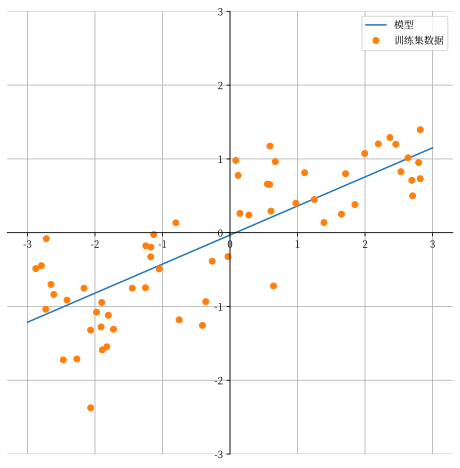

In [98]:
 from sklearn.linear_model import LinearRegression

X, y = make_wave(n_samples=60)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
line = np.linspace(-3, 3, 100).reshape(-1, 1)
lr = LinearRegression().fit(X_train, y_train)
print("斜率 w[0]: %f\n截距 b: %f" % (lr.coef_[0], lr.intercept_))

plt.figure(figsize=(8, 8))
plt.plot(line, lr.predict(line))
plt.plot(X, y, 'o')
ax = plt.gca()
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.set_ylim(-3, 3)
ax.legend(["模型", "训练集数据"])
ax.grid(True)

有许多不同的线性回归模型，区别在于如何从训练数据中学习参数 $w$ 和 $b$，以及如何控制模型复杂度。下面介绍常见的线性回归模型。

#### 3.3.2 线性回归（普通最小二乘法）

线性回归，或者叫**普通最小二乘法（ordinary least squares，OLS）**，是回归问题中最简单也最经典的线性方法。线性回归寻找参数 $w$ 和 $b$ 使得对训练集的 **均方误差（mean squared error）** 最小。均方误差是预测值与真实值之差的平方和与样本数 $n$ 的比值：

$$MSE = \frac{1}{n} \sum_{i=1}^{n}(\hat{y}_i - y_i)^2$$

线性回归没有参数，这是一种优点，但也是一种缺点。模型的复杂度由输入特征的数量决定，即模型的自由度很高。另一方面，由于没有参数，无法控制模型复杂度，模型的灵活性很低。

In [106]:
print("训练集 R^2：{}".format(lr.score(X_train, y_train)))
print("测试集 R^2：{}".format(lr.score(X_test, y_test)))

训练集 R^2：0.9520519609032728
测试集 R^2：0.6074721959665891


训练集和测试集的 $R^2$ 都不是很理想，说明模型欠拟合，不能很好地捕捉数据。对于这个一维数据集来说，过拟合的风险很小，因为模型非常简单（或者说非常受限）。但对于更高维的数据集（即特征更多的数据集），过拟合的风险会变大。

下面使用更大的波士顿房价数据集进行说明。该数据集有 506 个样本和 105 个导出特征。

In [107]:
X, y = make_extended_boston()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
lr = LinearRegression().fit(X_train, y_train)
print("训练集 R^2：{}".format(lr.score(X_train, y_train)))
print("测试集 R^2：{}".format(lr.score(X_test, y_test)))

训练集 R^2：0.9520519609032728
测试集 R^2：0.6074721959665891


可以发现，在训练集上的预测非常准确，但测试集上的 $R^2$ 低得多，说明模型过拟合。对于这种高维数据集，线性模型很难变得很强大。因此我们试图找到一个可以控制复杂度的模型。标准线性回归的最常用的替代方法之一是**岭回归（ridge regression）**。

#### 3.3.3 岭回归

岭回归公式与普通最小二乘法相同，但在岭回归中，对系数 $w$ 的选择不仅要求在训练集上得到好的预测效果，还要拟合附加约束，我们还希望系数尽可能小。换句话说，$w$ 的所有元素都应接近于 0。直观上来看，这意味着每个特征对输出的影响应尽可能小（即斜率很小），同时仍给出很好的预测结果。这种约束是所谓的**正则化（regularization）**。正则化是指对模型做显式约束，以避免过拟合。岭回归使用的是 L2 正则化。

岭回归在 `scikit-learn` 的 `linear_model.Ridge` 中实现。下面是使用波士顿房价数据集进行说明。

In [109]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train, y_train)
print("训练集 R^2：{}".format(ridge.score(X_train, y_train)))
print("测试集 R^2：{}".format(ridge.score(X_test, y_test)))

训练集 R^2：0.885796658517094
测试集 R^2：0.7527683481744747


可以看出，训练集上的 $R^2$ 分数要低于线性回归，但测试集上的分数要高很多。这和我们的预期一致，岭回归的泛化性能更好。由于我们只关心泛化性能，所以应该选择岭回归而不是线性回归。

`Ridge` 模型在模型的简单性（系数都接近于 0）与训练集性能之间做出权衡。简单性和训练集性能二者对于模型的重要程度可以由用户通过设置参数 `alpha` 来指定，默认参数 `alpha=1.0`。`alpha` 的最佳设定值取决于用到的具体数据集。增大 `alpha` 会使得系数更加趋向于 0，从而降低训练集性能，但可能会提高泛化性能。在实践中，调节 `alpha` 的最佳方法是创建一个 `alpha` 的取值范围，然后用交叉验证来找到最佳取值。

alpha = 10 时：
	训练集 R^2：0.7882787115369614
	测试集 R^2：0.6359411489177309
alpha = 0.1 时：
	训练集 R^2：0.9282273685001988
	测试集 R^2：0.7722067936479644


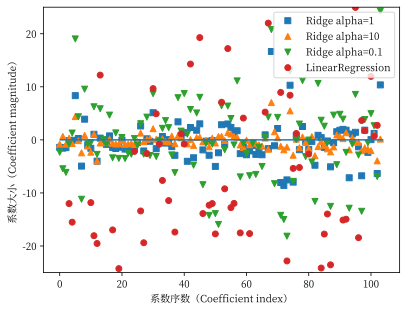

In [113]:
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("alpha = 10 时：")
print("\t训练集 R^2：{}".format(ridge10.score(X_train, y_train)))
print("\t测试集 R^2：{}".format(ridge10.score(X_test, y_test)))
ridge01 = Ridge(alpha=0.1).fit(X_train, y_train)
print("alpha = 0.1 时：")
print("\t训练集 R^2：{}".format(ridge01.score(X_train, y_train)))
print("\t测试集 R^2：{}".format(ridge01.score(X_test, y_test)))

plt.plot(ridge.coef_, 's', label="Ridge alpha=1")
plt.plot(ridge10.coef_, '^', label="Ridge alpha=10")
plt.plot(ridge01.coef_, 'v', label="Ridge alpha=0.1")
plt.plot(lr.coef_, 'o', label="LinearRegression")
plt.xlabel("系数序数（Coefficient index）")
plt.ylabel("系数大小（Coefficient magnitude）")
plt.hlines(0, 0, len(lr.coef_))
plt.ylim(-25, 25)
plt.legend()

这里 x 轴对应 `coef_` 的元素：x=0 对应第一个特征的系数，x=1 对应第二个特征的系数，依此类推，直到 x=100。y 轴对应的是每个系数的数值。`alpha=10` 的模型系数最小，`alpha=0.1` 时的模型系数最大。对于 `alpha=10`，系数几乎都为 0。对于没有做正则化的线性回归（即 `alpha=0`），点的范围很大，甚至超出图像范围。

另一种理解正则化影响的方法：固定 `alpha` 值，但改变训练数据量。对波士顿房价数据集做二次抽样，并在数据量逐渐增加的子数据集上分别对 `LinearRegression` 和 `Ridge(alpha=1)` 两个模型进行评估，将模型性能作为数据集大小的函数进行绘图（得到的图像叫**学习曲线**）。

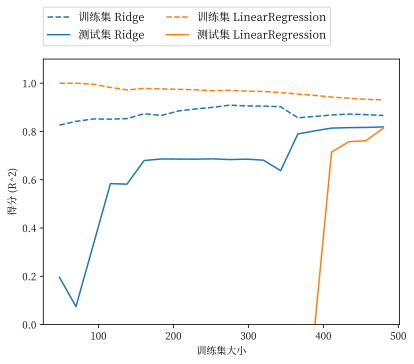

In [117]:
from sklearn.model_selection import learning_curve, KFold

def plot_learning_curve(est, X, y):
    training_set_size, train_scores, test_scores = learning_curve(
        est, X, y,
        train_sizes=np.linspace(.1, 1, 20),
        cv=KFold(20, shuffle=True, random_state=1),
    )
    estimator_name = est.__class__.__name__
    line = plt.plot(
        training_set_size,
        train_scores.mean(axis=1),
        '--',
        label="训练集 " + estimator_name
    )
    plt.plot(
        training_set_size,
        test_scores.mean(axis=1),
        '-',
        label="测试集 " + estimator_name, c=line[0].get_color()
    )
    plt.xlabel('训练集大小')
    plt.ylabel('得分 (R^2)')
    plt.ylim(0, 1.1)

plot_learning_curve(Ridge(alpha=1), X, y)
plot_learning_curve(LinearRegression(), X, y)
plt.legend(loc=(0, 1.05), ncol=2, fontsize=11)

无论是岭回归还是线性回归，所有数据集大小对应的训练集得分都高于测试集得分。由于岭回归是正则化的，因此在训练集上的得分低于线性回归，但测试集上的得分更高。对于较小的数据集（少于 400 个数据点），线性回归学不到任何内容。随着模型可用数据的增加，两个模型的性能都在提升，最终线性回归的性能达到了岭回归的性能。此外观察到，线性回归的训练性能在下降，如果添加更多的数据，模型将更加难以过拟合会哦记住所有数据。